# Preamble

This notebook contains information about running some initial analyses of color-concept association data, using Karen's original fruits dataset collected in the lab

## Libraries

Data are stored in Matlab files so we need the R.matlab library

In [31]:
#To read Matlab objects:
library(R.matlab)

#To do factor analysis
library(psych)

#To do matrix completion:
library(softImpute)

Warning message:
"package 'psych' was built under R version 3.6.3"Warning message:
"package 'softImpute' was built under R version 3.6.3"Loading required package: Matrix
Loaded softImpute 1.4



## Scripts

Here are some scripts to process and plot data

In [3]:
get.cor.mat <- function (d = alldat$FruitAssoc) 
{
#This function computes, for each subject and word, the
#correlation between the subject's ratings across colors
#and the mean of all other subject ratings across colors
#d is a 3D array containing the individual subject ratings
#formatted as in the original experiment
##########################

    nsj <- dim(d)[3] #Number of subjects
    nw <- dim(d)[2]  #Number of words
    o <- matrix(0, nw, nsj)  #Initialize output matrix
	
	#Loop over words and subjects to compute each correlation and
	#store in output matrix
    for (i in c(1:nw)) for (j in c(1:nsj)) {
        s <- d[, i, j]
        m <- rowMeans(d[, i, c(1:nsj) != j])
        o[i, j] <- cor(s, m)
    }
    o #Return output matrix
}


In [4]:
plot.cor.mat <- function (d) 
{
#This function plots the correlations of individual subject ratings
#with mean subject ratings for each word.
#d is a matrix output by get.cor.matrix
################################

    nw <- dim(d)[1] #Number of words
    nsj <- dim(d)[2] #Number of subjects
	
	#Generate blank plot
    plot(0, 0, type = "n", ylim = range(d), xlim = c(1, nw), 
        xlab = "Word", ylab = "Correlation")
		
	#Add individual subjects plotted as gray lines/dots
    for (i in c(1:nsj)) points(c(1:nw), d[, i], col = gray(0.8), 
        type = "o", pch = 16)
		
	#Add mean across subjects for each word as large black dot
    points(c(1:nw), rowMeans(d), pch = 16, cex = 2, col = 1)
	
    abline(h = 0) #Add horizontal line at r=0
}


In [37]:
test.complete <- function (d, p = 0.1, r = 4, plt = T, w = fruits, jc = judgedcols) 
{
#This function does matrix completion and plots results for
#a random hold-out set
#d: word-by-color matrix containing mean ratings
#p: Proportion of cells to use for hold-outs
#r: Maximum rank of matrix
#plt: Flag, should results be plotted?
#w: Character vector containing words
###########################################

    wm <- matrix(w, dim(d)[1], dim(d)[2]) #Matrix indicating word in each cell, for plotting later
	jcm <- t(matrix(jc, dim(d)[2], dim(d)[1])) #Matrix indicating color for each cell, for plotting later
    trn <- d #Make training matrix
    ncells <- dim(d)[1] * dim(d)[2] #How many cells in matrix?
    trn[sample(c(1:ncells), floor(p * ncells))] <- NA  #Remove hold-outs from training matrix
    m <- softImpute(trn, type = "als", rank.max = r) #Fit model
    pred <- complete(trn, m) #Make predictions for held-out items
	
	#Generate plot
    if (plt) {
        plot(d[!is.na(trn)], pred[!is.na(trn)], xlab = "True", 
            ylab = "Predicted", pch = 16, col = gray(0.8), xlim = range(d), 
            ylim = range(pred))
        points(d[is.na(trn)], pred[is.na(trn)], pch = 16,
			   col=jcm[is.na(trn)])
        text(d[is.na(trn)], pred[is.na(trn)], label = wm[is.na(trn)], 
            cex = 0.7, col=jcm[is.na(trn)])
    }
    cor(d[is.na(trn)], pred[is.na(trn)])
}


In [28]:
#Vector of fruit names
frnames <- c("Mango", "Watermelon","Honeydew", "Cantaloupe", "Grapefruit", 
             "Strawberry", "Raspberry", "Blueberry", "Avocado", "Orange", "Lime", "Lemon")

#Reaad in HEX values for the 58 judged colors from csv file
judgedcols <- read.csv("judgedcols.csv", header = F) #reads as data frame
judgedcols <- as.character(judgedcols[,1]) #convert to character vector

## Read data

In [5]:
alldat <- readMat("FruitData.mat")

## Analyses

In [6]:
#Compute subject correlations with mean
scm <- get.cor.mat(d = alldat$FruitAssoc)



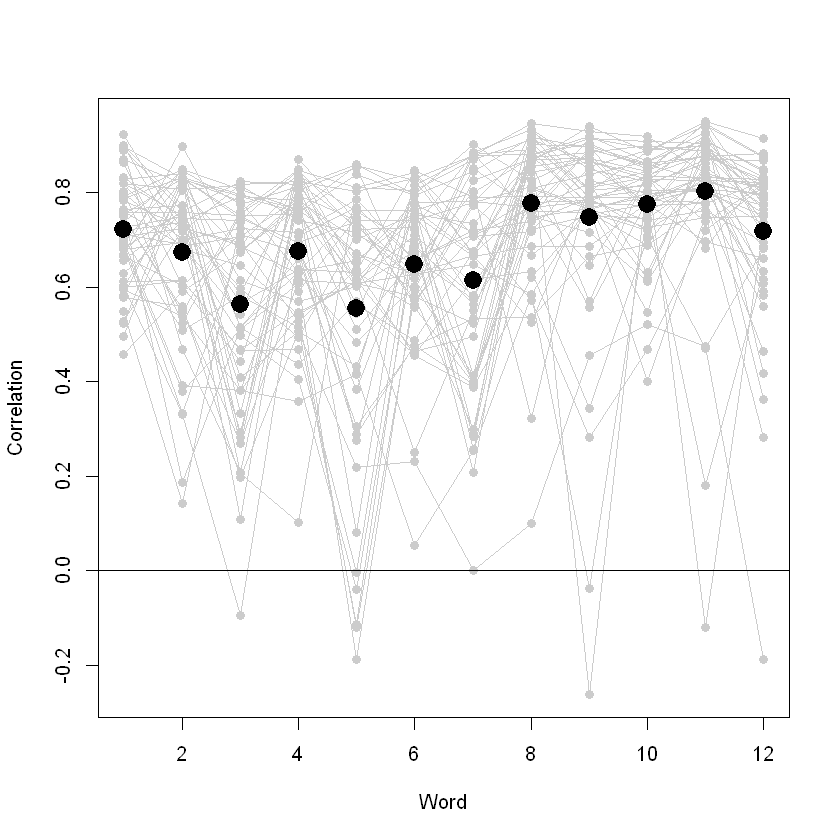

In [7]:
#Plot these
plot.cor.mat(scm)

Each gray dot/line is a single subject. Gray dots show, for each word, how the subject's ratings across the 58 colors correlate with the mean ratings across all other subjects. Lines connect the same subject across words. Black dots show mean correlation across subjects. If ratings across colors are reliable, individual subject ratings will show high correlations with the mean ratings, for most/all subjects. If there are some bad/unrepresentative participants, they will show up as straight lines far from the other subjects.

Now use apply to compute the mean word-color ratings across subjects, returning it as a word-by-color matrix:

In [15]:
#Compute mean ratings across all subjects
mnrating <- apply(alldat$FruitAssoc, c(2,1), "mean")
dim(mnrating)

[1] 12 58

You can plot the mean associations as a barplot, where bar color shows the corresponding color:

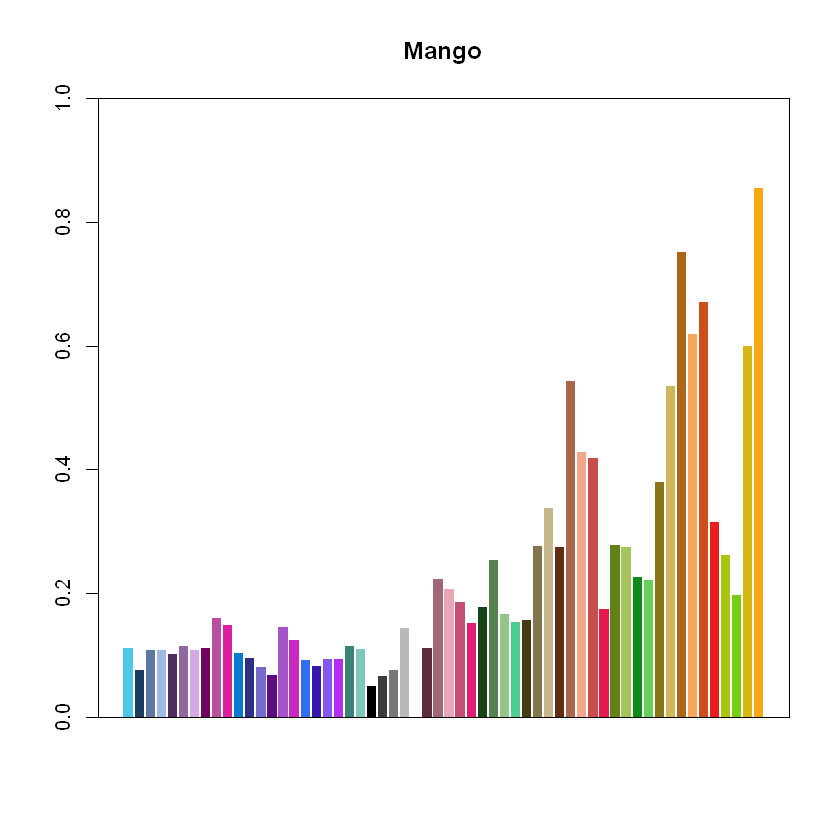

In [27]:
barplot(mnrating[1,], col=judgedcols, border = NA, ylim = c(0,1)); box(); title(frnames[1])

Here are plots for all 12:

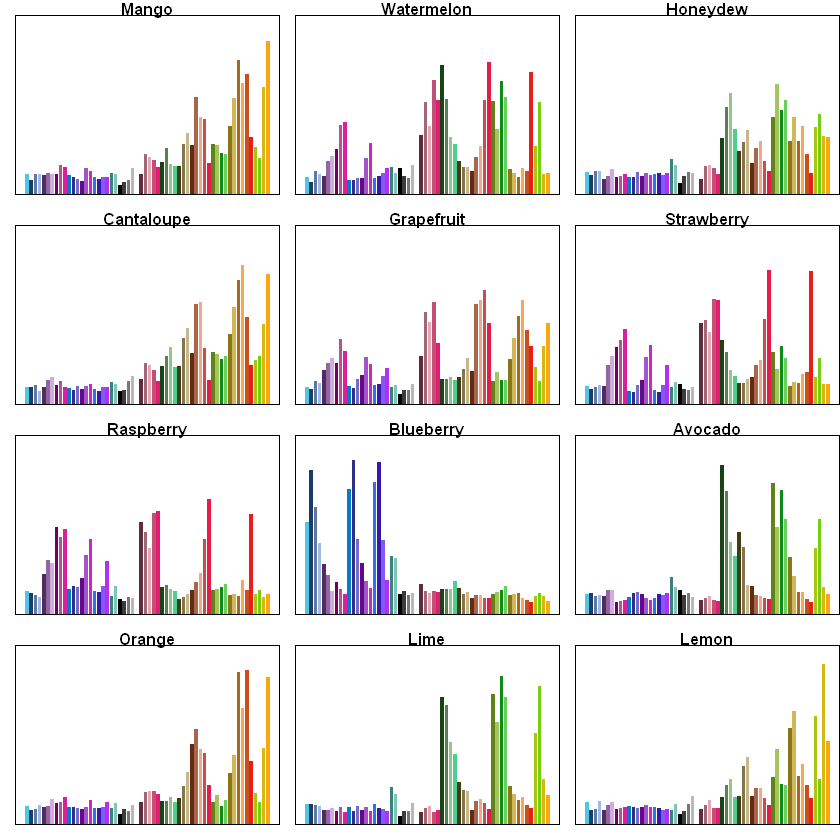

In [30]:
par(mfrow = c(4,3), mar = c(1,1,1,0))
for(i in c(1:12)){
    barplot(mnrating[i,], col=judgedcols, border = NA, ylim = c(0,1), yaxt = "n")
    box()
    title(frnames[i])
}

Is there low rank structure in the data? We can look at the eigenvalues of the fruitwise correlation matrix:

In [39]:
#Compute eigen decomposition of fruit-to-fruit correlation matrix.
#NOTE that you need to transform the mean rating matrix:
ev <- eigen(cor(t(mnrating)))

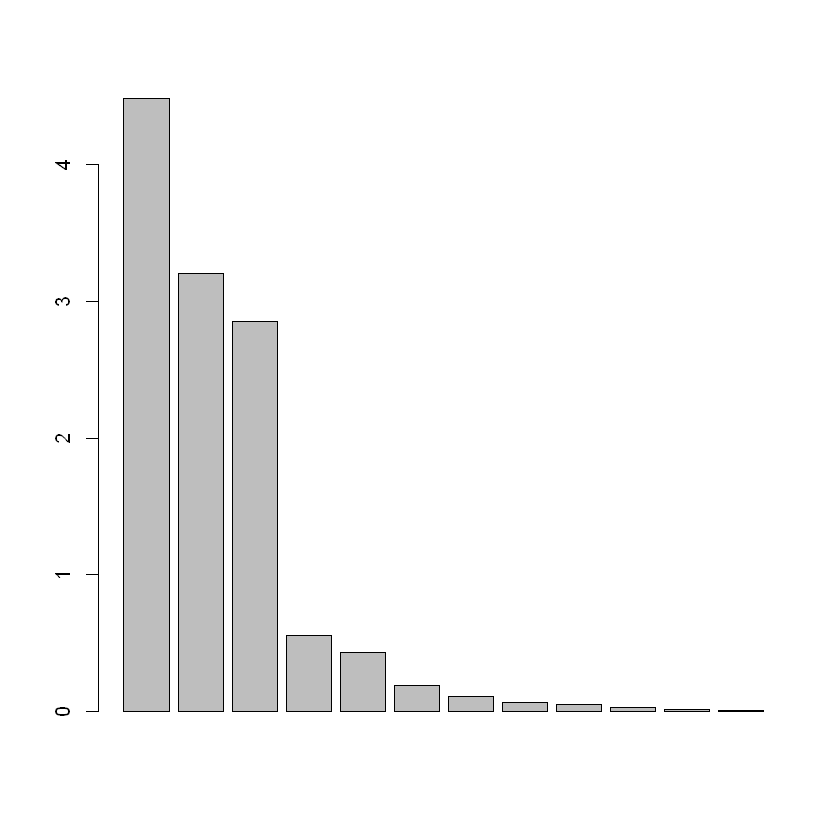

In [40]:
#Now plot the eigenvalues for each component
barplot(ev$values)

Looks like there are three components, so we can do matrix completion by specifying "rank 4". The test.complete function defined above runs the softImpute algorithm to complete a matrix using random holdouts, then computes accuracy on hold-out set and plots the results:

[1] 0.9330741

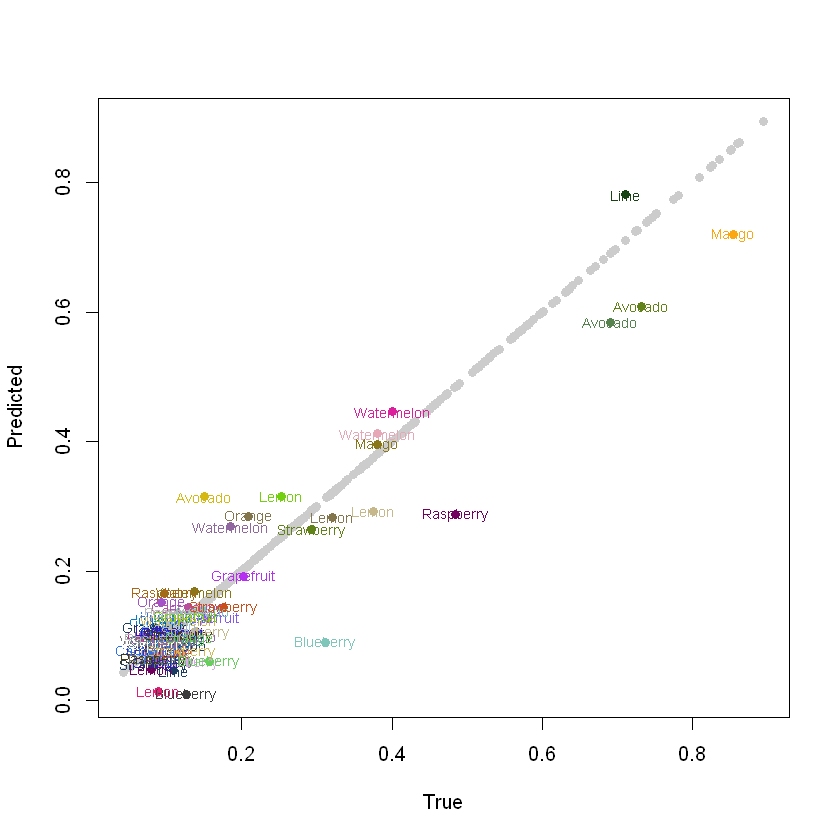

In [38]:
test.complete(mnrating, w = frnames, jc = judgedcols)